In [1]:
from __future__ import annotations

import os
import sys
import copy
import joblib
from pathlib import Path
from typing import Optional

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# -----------------------------------------------------------------------------
# Find project root –
# -----------------------------------------------------------------------------

def find_project_root(start_at: Optional[Path] = None, max_levels: int = 6) -> Path:
    here = start_at or Path.cwd()
    for _ in range(max_levels):
        if (here / "Training" / "Helper").is_dir():
            return here.resolve()
        if here.parent == here:
            break
        here = here.parent
    raise RuntimeError("Cannot locate project root containing Training/Helper")

try:
    _start = Path(__file__).resolve().parent  
except NameError:  
    _start = Path.cwd()

PROJECT_ROOT = find_project_root(_start)
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# -----------------------------------------------------------------------------
# Local imports
# -----------------------------------------------------------------------------

from Training.Helper.dataPreprocessing import (
    TRAIN_DATA_PATH_1990S,
    TEST_DATA_PATH_1990S,
    TRAIN_DATA_SPLIT,
    build_feature_matrix, # New Func for builder 
)
from Evaluation.Helper.evaluation_helpers import calc_metrics_arrays, display_results
from Training.Helper.RF_hyperparameters import tune_rf  # New Optuna Functions are added


In [11]:
# -----------------------------------------------------------------------------
# Config
# -----------------------------------------------------------------------------

DATE_COL = "observation_date"
RAW_TARGET_COL = "fred_PCEPI"  # original level series
TARGET_COL = "dlog_PCEPI"      # modelled target = log‑diff
EXOG_COLS = [
    "fred_AHETPI",
    "fred_GDP",
    "fred_PCUOMFGOMFG",
    "fred_A053RC1Q027SBEA",
    "fred_PPIACO",
    "fred_TERMCBPER24NS",
]

N_LAGS = 12
RANDOM_STATE = 42
N_OPTUNA_TRIALS = 40

MODEL_DIR = PROJECT_ROOT / "Training" / "Random_Forest"
MODEL_DIR.mkdir(parents=True, exist_ok=True)
PRED_DIR = PROJECT_ROOT / "Predictions"
PRED_DIR.mkdir(parents=True, exist_ok=True)

In [12]:
# -----------------------------------------------------------------------------
# Helpers
# -----------------------------------------------------------------------------

def add_log_diff(df: pd.DataFrame, *, src: str, dest: str) -> pd.DataFrame:
    df = df.copy()
    df[dest] = np.log(df[src]).diff()
    return df.dropna(subset=[dest]).reset_index(drop=True)


def forward_fill_initial_lags(X: pd.DataFrame, last_known_row: pd.Series) -> pd.DataFrame:
    #Fill NaNs in first N_LAGS lag rows from `last_known_row`
    lag_cols = [f"lag_{i}" for i in range(1, N_LAGS + 1)]
    X_ff = X.copy()
    X_ff.loc[: N_LAGS - 1, lag_cols] = X_ff.loc[: N_LAGS - 1, lag_cols].fillna(
        last_known_row[lag_cols]
    )
    return X_ff


In [13]:
# ---------------------------------------------------------------------------
# Load & split
# ---------------------------------------------------------------------------
raw_train = (
    pd.read_csv(TRAIN_DATA_PATH_1990S, parse_dates=[DATE_COL], date_format="%m/%Y")
    .query(f"{DATE_COL} >= '1990-01-01'")
    .sort_values(DATE_COL)
    .reset_index(drop=True)
)
train_df = add_log_diff(raw_train, src=RAW_TARGET_COL, dest=TARGET_COL)
X_all, y_all = build_feature_matrix(train_df, target_col=TARGET_COL, n_lags=N_LAGS, exog_cols=EXOG_COLS, drop_na=True)
split = int(len(X_all) * TRAIN_DATA_SPLIT)
X_tr, y_tr, X_val, y_val = X_all.iloc[:split], y_all.iloc[:split], X_all.iloc[split:], y_all.iloc[split:]

In [14]:
# ---------------------------------------------------------------------------
# Pipeline & Optuna tuning (uses new cv_splits arg)
# ---------------------------------------------------------------------------
rf_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("rf", RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)),
])

best_params = tune_rf(rf_pipe, X_tr, y_tr, n_trials=N_OPTUNA_TRIALS, cv_splits=5, random_state=RANDOM_STATE)
print("Best params:", best_params)

rf_pipe.fit(X_tr, y_tr)
print("Val metrics:\n", calc_metrics_arrays(y_val.values.reshape(-1,1), rf_pipe.predict(X_val).reshape(-1,1), model_names=["RF tuned"]))

[I 2025-04-27 19:22:18,361] A new study created in memory with name: no-name-008ee6b0-9035-430d-a6f5-1840ec70a0cb
[I 2025-04-27 19:22:22,410] Trial 0 finished with value: 0.001952218436285041 and parameters: {'n_estimators': 500, 'max_depth': 20, 'min_samples_leaf': 11, 'max_features': None}. Best is trial 0 with value: 0.001952218436285041.
[I 2025-04-27 19:22:27,488] Trial 1 finished with value: 0.002002267766057794 and parameters: {'n_estimators': 681, 'max_depth': 15, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.001952218436285041.
[I 2025-04-27 19:22:30,730] Trial 2 finished with value: 0.0019521886437032059 and parameters: {'n_estimators': 443, 'max_depth': 12, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 2 with value: 0.0019521886437032059.
[I 2025-04-27 19:22:34,824] Trial 3 finished with value: 0.001967642809399377 and parameters: {'n_estimators': 565, 'max_depth': 17, 'min_samples_leaf': 3, 'max_features': 0.5}. Best is trial 

Best params: {'n_estimators': 327, 'max_depth': 13, 'min_samples_leaf': 6, 'max_features': None}
Val metrics:
               RMSE       MAE        r2
RF tuned  0.002229  0.001681  0.017209


In [15]:
# -----------------------------------------------------------------------------
# Re‑fit on **all** available data
# -----------------------------------------------------------------------------

rf_full = copy.deepcopy(rf_pipe)
rf_full.fit(X_all, y_all)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('rf',
                 RandomForestRegressor(max_depth=13, max_features=None,
                                       min_samples_leaf=6, n_estimators=327,
                                       n_jobs=-1, random_state=42))])

In [16]:
# -----------------------------------------------------------------------------
# Test inference – forward‑fill + imputer
# -----------------------------------------------------------------------------

raw_test = pd.read_csv(TEST_DATA_PATH_1990S, parse_dates=[DATE_COL], date_format="%m/%Y")
raw_test = raw_test.sort_values(DATE_COL)
raw_test[TARGET_COL] = np.log(raw_test[RAW_TARGET_COL]).diff()
X_test, _ = build_feature_matrix(raw_test, target_col=TARGET_COL, n_lags=N_LAGS, exog_cols=EXOG_COLS, drop_na=False)

last_train_feat, _ = build_feature_matrix(train_df.tail(N_LAGS+1), target_col=TARGET_COL, n_lags=N_LAGS, exog_cols=EXOG_COLS)
X_test = forward_fill_initial_lags(X_test, last_train_feat.iloc[-1])

pred_dlog = rf_full.predict(X_test)
last_level = raw_train[RAW_TARGET_COL].iloc[-1]
level_forecast = last_level * np.exp(np.cumsum(pred_dlog))

In [17]:
horizons = [1, 3, 6, 12]           
horizon_preds: dict[int, np.ndarray] = {}

for h in horizons:
    shifted = np.concatenate(
        [level_forecast[h - 1 :], np.repeat(level_forecast[-1], h - 1)]
    )
    horizon_preds[h] = shifted

print({h: p.shape for h, p in horizon_preds.items()})


{1: (12,), 3: (12,), 6: (12,), 12: (12,)}


In [18]:
MODEL_PATH = MODEL_DIR / "Random_Forest_X.pkl"
joblib.dump(rf_full, MODEL_PATH)

for h, arr in horizon_preds.items():
    out_dir = PRED_DIR / f"Horizon{h}"
    out_dir.mkdir(parents=True, exist_ok=True)
    fname = out_dir / f"RFX_horizon_{h}.npy"
    np.save(fname, arr)

print("Artefacts written:")
print(" • Model  →", MODEL_PATH)
for h in horizons:
    print(f" • Horizon {h:>2} →", PRED_DIR / f"Horizon{h}" / f"RFX_horizon_{h}.npy")


Artefacts written:
 • Model  → C:\Users\44730\Desktop\RF Eval\COMP5530M-Group-Project-Inflation-Forecasting\Training\Random_Forest\Random_Forest_X.pkl
 • Horizon  1 → C:\Users\44730\Desktop\RF Eval\COMP5530M-Group-Project-Inflation-Forecasting\Predictions\Horizon1\RFX_horizon_1.npy
 • Horizon  3 → C:\Users\44730\Desktop\RF Eval\COMP5530M-Group-Project-Inflation-Forecasting\Predictions\Horizon3\RFX_horizon_3.npy
 • Horizon  6 → C:\Users\44730\Desktop\RF Eval\COMP5530M-Group-Project-Inflation-Forecasting\Predictions\Horizon6\RFX_horizon_6.npy
 • Horizon 12 → C:\Users\44730\Desktop\RF Eval\COMP5530M-Group-Project-Inflation-Forecasting\Predictions\Horizon12\RFX_horizon_12.npy


<Axes: title={'center': 'Actual vs. RF full (level) Predicted PCE'}, xlabel='Date', ylabel='Inflation'>

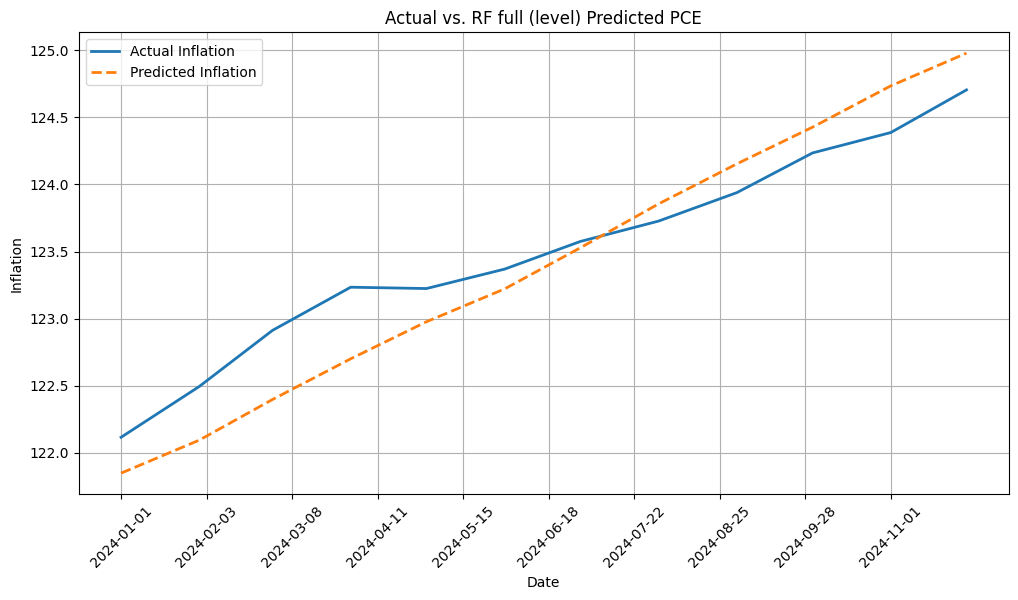

In [19]:
# ---------------------------------------------------------------------------
# Display test results (level) ------------------------------------------------
# ---------------------------------------------------------------------------

actual_levels = raw_test[RAW_TARGET_COL].iloc[-len(level_forecast):]
actual_dates  = raw_test[DATE_COL].iloc[-len(level_forecast):]

display_results(actual_levels, level_forecast, actual_dates, "RF full (level)")
